## Summary

----

## Imports

In [1]:
import os
import time
from pathlib import Path

import numpy as np
from IPython.display import HTML
from IPython.display import display
from tqdm.notebook import tqdm

import kmtools.sci_tools
import matplotlib.pyplot as plt
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch_geometric
from kmbio import PDB
from matplotlib.ticker import FuncFormatter
from torch_geometric.data import Batch

/dev/shm/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


## Properties

In [2]:
NOTEBOOK_NAME = "11_analyze_generated_sequences"

In [3]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/11_analyze_generated_sequences')

In [4]:
DESIGNS_PATH = NOTEBOOK_PATH.parent.joinpath("generate_protein_sequences")
assert DESIGNS_PATH.is_dir()

DESIGNS_PATH

PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences')

In [5]:
SEQUENCE_GENERATION_METHOD = "expectimax"

assert SEQUENCE_GENERATION_METHOD in ("astar", "randexpectimax", "expectimax", "logexpectimax", "root2expectimax", "root10expectimax")

In [6]:
# STRUCTURE_ID = "1n5uA03"
# STRUCTURE_ID = "4z8jA00"
STRUCTURE_ID = "4unuA00"
# STRUCTURE_ID = "4beuA02"

STRUCTURE_ID

'4unuA00'

In [7]:
STRUCTURE_FILE = NOTEBOOK_PATH.parent.parent.joinpath("data", "inputs", f"{STRUCTURE_ID}.pdb")
assert STRUCTURE_FILE.is_file()

STRUCTURE_FILE

PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/data/inputs/4unuA00.pdb')

In [8]:
REFERECE_PROBAS = {
    #
    "4unuA00": {
        "avg_proba": 0.31404372748978643,
        "avg_logproba": -1.71758739226455,
        "seq_identity": 0.4036697247706422,
    }
}

## Load structure

In [9]:
structure_all = PDB.load(STRUCTURE_FILE)
structure = PDB.Structure(STRUCTURE_FILE.name + "A", structure_all[0].extract('A'))
assert len(list(structure.chains)) == 1

In [10]:
view = PDB.view_structure(structure)

view

_ColormakerRegistry()

NGLWidget()

## Design pipeline

### Load protein sequence and geometry

In [13]:
pdata = proteinsolver.utils.extract_seq_and_adj(STRUCTURE_FILE, 'A')
print(pdata)

ProteinData(sequence='SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL', row_index=array([  0,   0,   0, ..., 106, 106, 107]), col_index=array([  1,   2,   3, ..., 107, 108, 108]), distances=array([1.29767875, 3.76060342, 6.58874989, ..., 1.32708647, 4.12791238,
       1.32601478]))


In [14]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
print(data.edge_attr.min())
data = proteinsolver.datasets.protein.transform_edge_attr(data)
print(data.edge_attr.min())

tensor(1.2700)
tensor(-1.4971)


In [15]:
sequence_ref = pdata.sequence
print(len(sequence_ref), sequence_ref)

109 SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL


### Convert designs into a DataFrame

In [16]:
design_files = list(DESIGNS_PATH.glob(f"designs-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}-*.parquet"))
design_files[-5:]

[PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-expectimax-4unuA00-1067.parquet'),
 PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-expectimax-4unuA00-3016.parquet'),
 PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-expectimax-4unuA00-5052.parquet'),
 PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-expectimax-4unuA00-5056.parquet'),
 PosixPath('/lustre04/scratch/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-expectimax-4unuA00-3012.parquet')]

In [17]:
dfs = []
for design_file in tqdm(design_files):
    df = pq.read_table(design_file).to_pandas(integer_object_nulls=True)
    dfs.append(df)
df = pd.concat(dfs, sort=False)

In [18]:
print(len(df))
df = df.drop_duplicates(subset=["sequence"])
print(len(df))

3736564
3736564


In [19]:
df.head(2)

,sequence,probas_sum,probas_log_sum
0,GSLSNSIGATGKAGGIVSMTCCGNSGSVAGHRLITWYWLKGGGELR...,32.550484,-196.917572
1,GLFVNPAAGNGLEGDTVTVACTGTDDTISGRDTITWYWKNNGDLQQ...,36.391975,-174.527679


In [20]:
df["seq_identity"] = [
    sum(sequence_ref[i] == sequence[i] for i in range(len(sequence_ref))) / len(sequence_ref)
    for sequence in df["sequence"]
]

In [21]:
df.head(2)

,sequence,probas_sum,probas_log_sum,seq_identity
0,GSLSNSIGATGKAGGIVSMTCCGNSGSVAGHRLITWYWLKGGGELR...,32.550484,-196.917572,0.293578
1,GLFVNPAAGNGLEGDTVTVACTGTDDTISGRDTITWYWKNNGDLQQ...,36.391975,-174.527679,0.357798


## Make plots

### Sequence identity

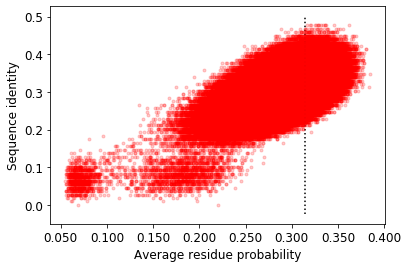

In [31]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    ax.plot(df["probas_sum"] / len(sequence_ref), df["seq_identity"], "r.", alpha=0.2)
    ax.set_xlabel("Average residue probability")
    ax.set_ylabel("Sequence identity")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3f}"))
    if STRUCTURE_ID in REFERECE_PROBAS:
        ax.vlines(REFERECE_PROBAS[STRUCTURE_ID][0], *ax.get_ylim(), linestyles=":")

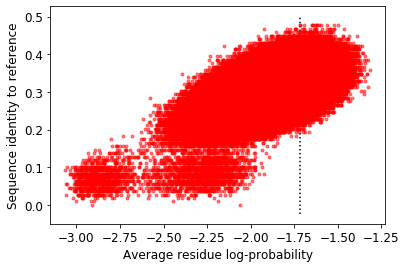

In [33]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots()
    ax.plot(
        df["probas_log_sum"] / len(sequence_ref), df["seq_identity"], "r.", alpha=0.5
    )
    ax.set_xlabel("Average residue log-probability")
    ax.set_ylabel("Sequence identity to reference")
    if STRUCTURE_ID in REFERECE_PROBAS:
        ax.vlines(REFERECE_PROBAS[STRUCTURE_ID][1], *ax.get_ylim(), linestyles=":")

### Adjacency matrix

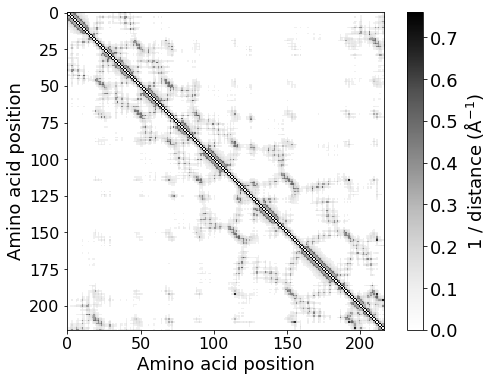

In [21]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
adj = torch_geometric.utils.to_dense_adj(edge_index=data.edge_index, edge_attr=1 / data.edge_attr[:, 0]).squeeze()

with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    out = ax.imshow(adj, cmap="Greys")
    ax.set_ylabel("Amino acid position")
    ax.set_xlabel("Amino acid position")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("1 / distance (Å$^{-1}$)")

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-adjacency.svg"))

### Score distributions

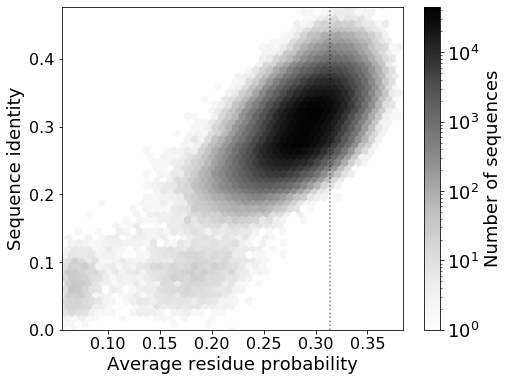

In [44]:
with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    x = df["probas_sum"] / len(sequence_ref)
    #     x = np.exp(df["probas_log_sum"] / df["sequence"].str.len())
    y = df["seq_identity"].values
    #     y = df["seq_identity"].values + 0.005 * np.random.randn(len(df))
    out = ax.hexbin(x, y, gridsize=50, bins="log", cmap="Greys")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_ylabel("Sequence identity")
    ax.set_xlabel("Average residue probability")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("Number of sequences")
    if STRUCTURE_ID in REFERECE_PROBAS:
        ax.vlines(REFERECE_PROBAS[STRUCTURE_ID][0], *ax.get_ylim(), linestyles=":", alpha=0.5)

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-hexbin.svg"))

### Sequence logo

In [23]:
kmtools.sci_tools.make_weblogo(
    df["sequence"].values,
    units="probability",
    color_scheme="hydrophobicity",
    stacks_per_line=110,
    format_="svg",
    output_file=NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-gen.svg"),
)

In [24]:
kmtools.sci_tools.make_weblogo(
    [sequence_ref],
    units="probability",
    color_scheme="hydrophobicity",
    stacks_per_line=110,
    format_="svg",
    output_file=NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-wt.svg"),
)

In [25]:
!head {NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-gen.svg")}

<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="1226pt" height="150pt" viewBox="0 0 1226 150" version="1.1">
<defs>
<g>
<symbol overflow="visible" id="glyph0-0">
<path style="stroke:none;" d=""/>
</symbol>
<symbol overflow="visible" id="glyph0-1">
<path style="stroke:none;" d="M 0.3125 -4.25 L 0.3125 -3.59375 L 0.46875 -2.78125 L 0.703125 -2.78125 L 0.875 -3.59375 L 0.875 -4.25 Z M 1.265625 -4.25 L 1.265625 -3.59375 L 1.4375 -2.78125 L 1.671875 -2.78125 L 1.828125 -3.59375 L 1.828125 -4.25 Z M 1.265625 -4.25 "/>
</symbol>


In [26]:
display(HTML(f"""\
<div style="overflow: scroll; width: 100%">
<p style="text-align: center; margin-bottom: 0px"><b>Wild-type</b></p>
<img src="{NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-wt.svg").relative_to(Path.cwd())}" style="width: 100%"/>

<p style="text-align: center; margin-bottom: 0px"><b>Designs</b></p>
<img src="{NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-gen.svg").relative_to(Path.cwd())}" style="width: 100%"/>
</div>
"""))